<a href="https://colab.research.google.com/github/adamgogacz/time-series-processing/blob/main/bandpass_filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Filter window based on the difference of two Gaussian CDFs

In [1]:
import numpy as np
from matplotlib import pyplot as plt 
from scipy.stats import norm
from scipy.fft import fft, ifft
import bottleneck as bn
%matplotlib inline
plt.rcParams.update({'font.size': 8})

In [2]:
def cdf_diff(mu_1:float, sigma_1:float, mu_2:float, sigma_2:float):
    'Difference of 2 Gaussian CDFs'
    xmax=mu_2+mu_1+2.5*sigma_2
    xarr=np.linspace(0,1.5*xmax,int(3*xmax))
    # functions
    win=norm.cdf(xarr,loc=mu_1,scale=sigma_1)-norm.cdf(xarr,loc=mu_2,scale=sigma_2)
    print(str(win[0])+" "+str(win[-1]))
    X=np.abs(fft(win,n=len(win)))
    X=X/X.max(); X[X==0.0]=1.0/2**51
    XdB=20.0*np.log10(X)
    filt=np.real(ifft(win))
    filt=np.fft.ifftshift(filt)
    return (win, XdB, filt)

In [145]:
def gauss(sig:np.ndarray, loc:float, scale:float):
    'Gaussian window filter'
    assert np.mod(len(sig),1) == 0, 'Length of signal must be odd'
    Nsig=len(sig)
    Nrfft=Nsig//2
    xarr=np.linspace(0,Nrfft/(2*Nrfft),Nrfft)
    WIN=norm.pdf(xarr,loc=loc,scale=scale)
    WIN=np.concatenate((WIN, np.array([0.0,0.0]), np.flip(WIN[:-1])))
    FSINC=WIN*fft(sinc(Nsig))
    filt=np.real(ifft(FSINC))
    # filt=np.fft.ifftshift(filt)
    filt=filt/np.sum(np.abs(filt))
    sigfilt=np.convolve(sig,filt,mode='same')
    return (sig, sigfilt, WIN)


In [119]:
def sinc(Nsamp:int=1001):
  'Sinc filter'
  Nsamp=2*(Nsamp//2)+1
  xarr=np.linspace(-Nsamp//2.25,Nsamp//2.25,Nsamp)
  fsinc=np.sinc(xarr)
  # X=np.abs(fft(fsinc,n=len(fsinc)))
  # X=X/X.max(); X[X==0.0]=1.0/2**51
  # XdB=20.0*np.log10(X)
  # filt=np.real(ifft(fsinc))
  # filt=np.fft.ifftshift(filt)
  # ANG=np.fft.ifftshift(np.unwrap(np.angle(np.fft.fft(X))))
  # return (fsinc, XdB, filt)
  return fsinc

In [134]:

def plotResults(sig:np.ndarray, filt:np.ndarray, WIN:np.ndarray):   
    fig, axs=plt.subplots(2, 3)
    fig.set_size_inches(30, 10)
    # fig.suptitle(f'mu_1={mu_1}, mu_2={mu_2}, and sigma_1=sigma_2={sigma_1}')
    #--- signal function 
    idxSigmin=0; idxSigmax=len(sig)-1
    xsig=np.arange(len(sig))
    axs[0,0].plot(xsig[idxSigmin:idxSigmax],sig[idxSigmin:idxSigmax])
    axs[0,0].set_xlabel('Sample')
    axs[0,0].set_xlim(xsig[idxSigmin],xsig[idxSigmax])
    axs[0,0].set_title(label='Input signal',fontdict=None, loc='center', pad=None)
    #--- FFT amplitude of the input signal
    SIG=np.abs(fft(sig))
    freqs=np.fft.fftfreq(len(SIG),1)
    axs[0,1].plot(freqs,SIG)
    axs[0,1].set(xlabel='Freq (normalized)', ylabel='FFT Amplitude')
    axs[0,1].set_xlim(freqs.min(),freqs.max())
    axs[0,1].set_title(label='FFT amplitude of input signal',fontdict=None, loc='center', pad=None)
    #--- FFT amplitude of the window function
    freqs=np.fft.fftfreq(len(WIN),1)
    axs[0,2].plot(freqs,WIN)
    axs[0,2].set(xlabel='Freq (normalized)', ylabel='FFT Amplitude')
    axs[0,2].set_ylim(WIN.min(),WIN.max())
    axs[0,2].set_xlim(freqs.min(),freqs.max())
    axs[0,2].set_title(label='FFT window function',fontdict=None, loc='center', pad=None)
    #--- filtered signal
    idxmin=0; idxmax=len(filt)-1
    xfilt=np.arange(len(filt))
    axs[1,0].plot(xfilt[idxmin:idxmax],filt[idxmin:idxmax])
    axs[1,0].set_xlabel('Sample')
    axs[1,0].set_xlim(xfilt[idxmin],xfilt[idxmax])
    axs[1,0].set_title(label='Filtered',fontdict=None, loc='center', pad=None)
    #--- FFT amplitude of the filtered signal
    SIG_FILT=np.abs(fft(filt))
    freqs=np.fft.fftfreq(len(SIG_FILT),1)
    axs[1,1].plot(freqs,SIG_FILT)
    axs[1,1].set(xlabel='Freq (normalized)', ylabel='FFT Amplitude')
    axs[1,1].set_xlim(freqs.min(),freqs.max())
    axs[1,1].set_title(label='FFT amplitude of filtered signal',fontdict=None, loc='center', pad=None)
    #--- final adjsutments
    #fig.tight_layout()
    plt.show()

In [123]:
def genSweep(f0:float, f1:float, Nsamp:int):
  x=np.linspace(0,1,Nsamp)
  return np.sin(2.*np.pi*(f0*x+((f1-f0)/2.)*x**2))

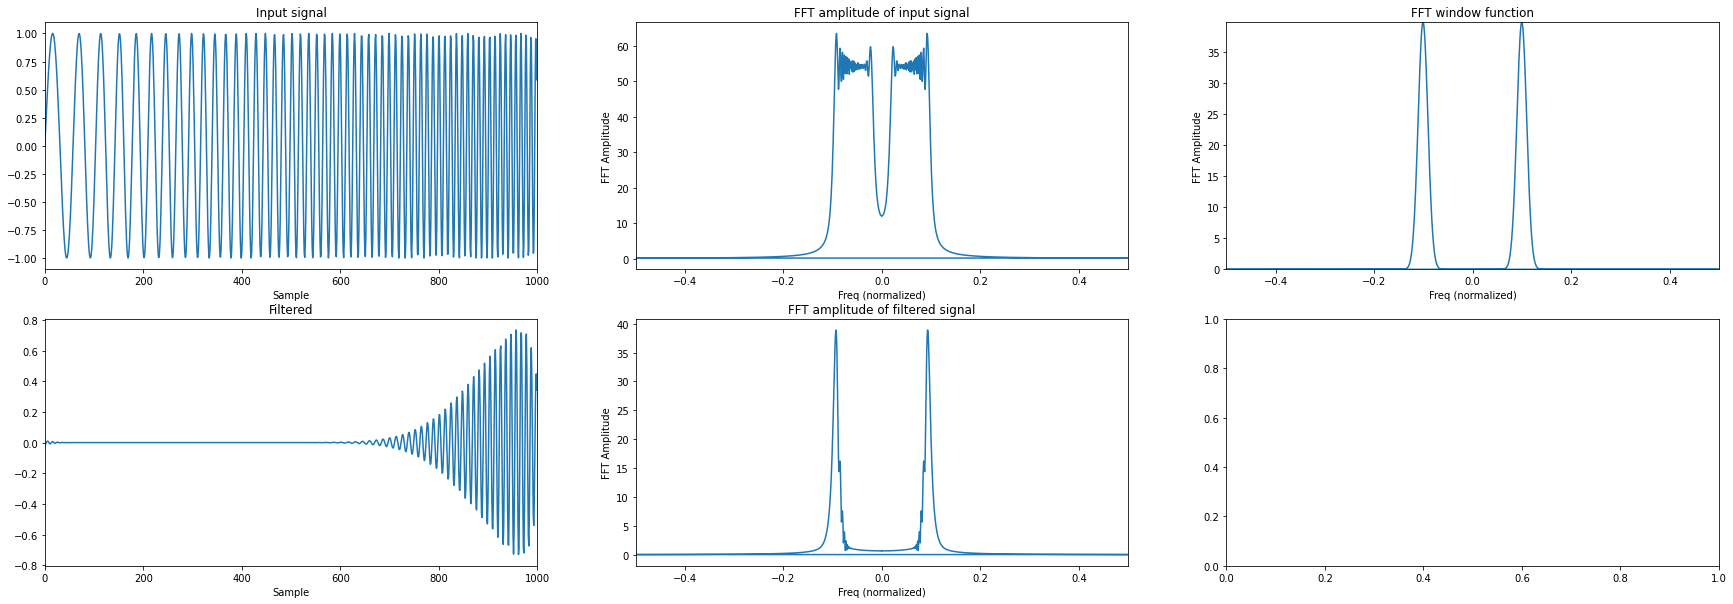

In [150]:
def main():
    mu_1=0.1;         mu_2=300
    sigma_1=0.01;    sigma_2=30
    f0=15;           f1=100;
    sweep=genSweep(f0,f1,1001)
    # win, XdB, filt=cdf_diff(mu_1,sigma_1,mu_2,sigma_2)
    sig, filt, WIN = gauss(sig=sweep, loc=mu_1, scale=sigma_1)
    plotResults(sig, filt, WIN)
    
if __name__=="__main__":
    main()

In [ ]:
q=np.arange(10)
print(q)
print(q[:-1])